In [1]:
using DSP
using ITensorTDVP
using ITensors
using LinearAlgebra
using Observers
using Plots
using ProgressBars
using Trapz
using InteractiveUtils
using Distributed
using SharedArrays
using Dates
using JLD2
using Printf
using PolyChaos
using LaTeXStrings
using Kronecker
using SparseArrays
addprocs(12)
@everywhere include("Graphing_fns.jl")
@everywhere include("module_PreB_fns_using_structs.jl")
using .PreB_fns_using_structs
using .Graphing_fns
"""
Put Quantum numbers in.
"""

"""
MAKE SURE THE HAMILTONIAN HAS THE CORRECT MINUSES FROM THE NOTES.
MAKE SURE THE ORDER OF THE COUPLING TERMS IN THE HAMILTONIAN ARE CORRECT
(i.e. whether you have to switch Cdag and C)
"""

"MAKE SURE THE HAMILTONIAN HAS THE CORRECT MINUSES FROM THE NOTES.\nMAKE SURE THE ORDER OF THE COUPLING TERMS IN THE HAMILTONIAN ARE CORRECT\n(i.e. whether you have to switch Cdag and C)\n"

In [31]:
function current_operator(corr,ind,DP,P,BP)
    (;Nbl,Ns) = P
    (;N,ti,left_bath_bool,right_bath_bool) = DP
    (;H_single) = BP
    
    corr_bool = (size(corr)[1] == N)
    corr_ind = ind - (1-Int(bool))*2*Nbl
    step = Int(corr_bool)+1  
    
    """
    ind is the index comparative to all the modes including the bath modes.
    """
    if ind-2 < 2*Nbl 
        if corr_bool
            t1,t2 = H_single[ind-2,ind],H_single[ind-1,ind]
            JB_L = t1*corr[ind,ind-2] - conj(t1)*corr[ind-2,ind]
            JA_L = t2*corr[ind,ind-1] - conj(t2)*corr[ind-1,ind]
            JL = im*(JB_L + JA_L)
        else
            JL = perturb_J(corr,P,DP,BP)
        end
    else
        t1 =  H_single[ind-step,ind]
        JL = im*(t1*corr[corr_ind,corr_ind-step] - conj(t1)*corr[corr_ind-step,corr_ind])
    end
            
    if ind+2>(2*Nbl+Ns)
        if corr_bool
            t1,t2 = H_single[ind+2,ind],H_single[ind+3,ind]
            JB_R = t1*corr[ind,ind+2] - conj(t1)*corr[ind+2,ind]
            JA_R = t2*corr[ind,ind+3] - conj(t2)*corr[ind+3,ind]
            JR = -im*(JB_R + JA_R)
        else
            """
            Do perturbation thing
            """
        end
    else
        t1 = H_single[ind,ind+step]
        JR = im*(t1*corr[ind+step,ind] - conj(t1)*corr[ind,ind+step])
    end
    n = corr[corr_ind,corr_ind]
    return JL,JR,n
end
          

function Fock_states(P,DP)
    ##given Ns sites, there are 2^Ns fock states.
    (;Ns) = P
    (;qS) = DP
    fock_list = Vector{Vector{Any}}()
    eig_state = ITensor(s[qS])
    eig_state_arr = 0*Array{ComplexF64}(eig_state,s[qS])
    for j=0:((2^Ns)-1)
        #sum(inds) gives the number occupation of basis state s[qS] = x.
        inds = split(bitstring(Int16(j)),"")
        x =  ([parse(Int8,inds[k]) for k in (16-Ns+1):16] .+1)
        @show(sum(x.-1))
        fockstate = copy(eig_state_arr)
        fockstate[CartesianIndex(Tuple(x))] = 1
        Num = sum(x .-1) ##number occupation
        push!(fock_list,[fockstate,Num])
    end
    return fock_list
end

function perturb_J(ρ,P,DP,BP)
    """
    -Assuming ρ is in matrix form at this point.
    """
    
    """
    Need to calculate the set of number conserving states for the ancillas. To do this for a given system size Ns,
    we want to know the number occupation of each of the fock states.
    """
    (;Ns) = P
    (;s,qS,qA) = DP
    (;H) = BP
    spec = eigen(ρ).values
    vecs = eigen(ρ).vectors
    NESS_MPS = 0*randomMPS(s[qS],linkdims=1)
    Fock_list = Fock_states(P,DP)
    NESS_ITensor = ITensor(s[qS],s[qA])
    @show(size(ρ)[1])
    for i =1:size(ρ)[1]
        anc_Tensor = ITensor(s[qA])
        eig_Tensor = ITensor(s[qS])
        anc_arr = 0*Array{ComplexF64}(anc_Tensor,s[qA])
        eig_arr = 0*Array{ComplexF64}(eig_Tensor,s[qS]) 
        
        ##Creates the eigenstate in tensorial form
        for j=0:((2^Ns)-1) 
            inds = split(bitstring(Int16(j)),"")
            x =  ([parse(Int8,inds[k]) for k in (16-Ns+1):16] .+1)
            
            ##Is this the correct reshape of the \rho basis from vectorised to tensorial? I think so
            eig_arr[CartesianIndex(Tuple(x))] = vecs[j+1,i] ##j starts from 0
        end
        eig_Tensor = ITensor(eig_arr,s[qS])
        eig_MPS = MPS(eig_Tensor,s[qS])
        
        ##Calculating the number occupation for the ith eigenstate, and extracting the appropriate Fock basis state
        ##for the ancillas such that the total MPS when combined will have an occupation number Ns.
        Num = sum(expect(eig_MPS,"N"))
        index = findfirst(Fock -> Fock[2] == Ns-Num, Fock_list)
        @show(Ns-Num)
        @show(length(Fock_list))
        @show(index)
       # splice!(Fock_list,index)
#         anc_Tensor = ITensor((Fock_list[index])[1],s[qA])
#         Full_Tensor = eig_Tensor*anc_Tensor

        
#         NESS_ITensor += Full_Tensor*√(spec[i])
    end
    NESS_MPS = MPS(NESS_ITensor,s[qS],s[qA])
    return NESS_MPS       
end
ρ = unvectorise_ρ(vectorise_ρ(ψ_init,P,DP),true)
perturb_J(ρ,P,DP,BP)

sum(x .- 1) = 0
sum(x .- 1) = 1
sum(x .- 1) = 1
sum(x .- 1) = 2
sum(x .- 1) = 1
sum(x .- 1) = 2
sum(x .- 1) = 2
sum(x .- 1) = 3
(size(ρ))[1] = 8
Ns - Num = 1.746485118182177
length(Fock_list) = 8
index = nothing
Ns - Num = 1.2754204421017774
length(Fock_list) = 8
index = nothing
Ns - Num = 1.756866526231636
length(Fock_list) = 8
index = nothing
Ns - Num = 1.7907852179640527
length(Fock_list) = 8
index = nothing
Ns - Num = 2.386129260572654
length(Fock_list) = 8
index = nothing
Ns - Num = 1.6196295928801874
length(Fock_list) = 8
index = nothing
Ns - Num = 1.3967754838994626
length(Fock_list) = 8
index = nothing
Ns - Num = 1.8538537591987274
length(Fock_list) = 8
index = nothing


LoadError: MethodError: [0mCannot `convert` an object of type [92mITensor[39m[0m to an object of type [91mVector{ITensor}[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Strided.AbstractStridedView[39m) where T<:Array at C:\Users\mf22297\.julia\packages\Strided\pDrSx\src\abstractstridedview.jl:31
[0m  convert(::Type{Array{T, N}}, [91m::StaticArraysCore.SizedArray{S, T, N, N, Array{T, N}}[39m) where {S, T, N} at C:\Users\mf22297\.julia\packages\StaticArrays\J9itA\src\SizedArray.jl:88
[0m  convert(::Type{Array{T, N}}, [91m::StaticArraysCore.SizedArray{S, T, N, M, TData} where {M, TData<:AbstractArray{T, M}}[39m) where {T, S, N} at C:\Users\mf22297\.julia\packages\StaticArrays\J9itA\src\SizedArray.jl:82
[0m  ...

In [4]:
#function vectorise_ρ_(ψ,P,DP)
#         """
#         In order for the rdm to be valid here, the ordering of qS and qA must be separated. This function
#         assumes that the input state has an interleaved ordering, so the required swap and phase gates are applied.
        
#         """
#         """
#         Do you do the particle hole transform here or not? 
#         """
(;s,q,qS,c,cdag) = DP

Ns = length(qS)
gates =  ancilla_phase_gate_swap(DP,P)
@show(gates[1])
ψ = apply(gates[1],ψ)
# for i = 1:length(gates)
#     println(i)
#     println(gates[i])
#     println(ψ)
#     ψ = apply(gates[i],ψ)
# end


###Applies fermionic swap gates to change the order from interleaved to separated
ψ = system_swaps(ψ,q[1],DP,P)
qA =  q[Ns+1:2*Ns]
qS =  q[1:Ns]


#combined all system legs together
Cs = combiner(s[qS])
Css = combiner([inds(Cs)[1],inds(Cs)[1]'])
#Creating the evolved system density matrix 
rm_inds = qS
ρ = rdm(ψ,rm_inds,DP,P)
ρ = ρ*Cs*Cs'
ρ = ρ*Css
ρ = Array(ρ,inds(ρ))
#   return ρ
#end
#ρ = vectorise_ρ_(ψ_init,P,DP)

gates[1] = ITensor ord=4
Dim 1: (dim=2|id=875|"Fermion,Site,n=14")
Dim 2: (dim=2|id=463|"Fermion,Site,n=12")
Dim 3: (dim=2|id=875|"Fermion,Site,n=14")'
Dim 4: (dim=2|id=463|"Fermion,Site,n=12")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 -0.9999999999999999 - 1.5269510447359755e-16im  0.0 + 0.0im
                 0.0 + 0.0im                     0.0 + 0.0im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.0im
 0.9999999999999999 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im  0.9999999999999999 + 0.0im
 0.0 + 0.0im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.0im                 0.0 + 0.0im
 0.0 + 0.0im  0.9999999999999999 + 0.0im


64-element Vector{ComplexF64}:
     0.12500000000000008 + 4.60662331846049e-18im
 -5.5180190753293696e-18 - 8.257972956148302e-18im
  -1.612641234942469e-17 - 8.677739188104198e-17im
 -4.1193408579128845e-18 + 1.162994536800874e-17im
 -2.4352808836680625e-18 + 5.8222128092930175e-18im
  1.2829686816384539e-17 + 2.7538233554797755e-18im
 -2.2535407826415346e-17 - 1.1576168032607706e-17im
   5.777106368586296e-17 - 1.824880395572097e-17im
   3.546096213556565e-18 + 2.511151825344464e-18im
                   0.125 + 1.2036704078462676e-18im
  1.1141690768053944e-17 - 4.842134696809377e-17im
 -2.6904329889218313e-17 + 7.93000172727185e-18im
 -3.0776553914029946e-17 + 2.1879934792789453e-17im
                         ⋮
  -9.414373693161877e-17 + 2.3577284497042145e-17im
 -1.3345513040783884e-17 + 3.532791750678671e-18im
     0.12499999999999999 - 8.412625843741918e-18im
   2.286389157970238e-17 - 3.847927234845852e-18im
  5.1437749692595433e-17 + 5.181252164358591e-18im
   7.690323917807362

In [13]:
gates =  ancilla_phase_gate_swap(DP,P)

3-element Vector{Any}:
 ITensor ord=4
Dim 1: (dim=2|id=738|"Fermion,Site,n=14")
Dim 2: (dim=2|id=529|"Fermion,Site,n=12")
Dim 3: (dim=2|id=738|"Fermion,Site,n=14")'
Dim 4: (dim=2|id=529|"Fermion,Site,n=12")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 -0.9999999999999999 - 1.5269510447359755e-16im  0.0 + 0.0im
                 0.0 + 0.0im                     0.0 + 0.0im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.0im
 0.9999999999999999 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im  0.9999999999999999 + 0.0im
 0.0 + 0.0im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.0im                 0.0 + 0.0im
 0.0 + 0.0im  0.9999999999999999 + 0.0im
 ITensor ord=4
Dim 1: (dim=2|id=856|"Fermion,Site,n=16")
Dim 2: (dim=2|id=529|"Fermion,Site,n=12")
Dim 3: (dim=2|id=856|"Fermion,Site,n=16")'
Dim 4: (dim=2|id=529|"Fermion,Site,n=12")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 -0.9999999999999999 - 1.5269510447359755e-16im

In [2]:
Nbl ::Int64 = 5                                #Number of left bath sites
Nbr ::Int64 = 5                               #Number of right bath sites
Ns  ::Int64 = 3                                  #Number of system sites (not including ancilla)  
Kr_cutoff ::Float64 = 1E-5                       #Cutoff used in Krylov expansion
D ::Float64 = 1                                #Half bandwidth
mu_L ::Float64 = -0.3#D/16                            
mu_R ::Float64 = 0.3#-D/16
k1 ::Int64 = 3                                   # Number of Krylov states
τ_Krylov ::Float64 = 1
Γ_L ::Float64 = 0.1#(D/15)
Γ_R ::Float64 = 0.1#(D/15)
β_L ::Float64 = 0.2#1/(5*D)                                      #inverse temperature of right bath
β_R ::Float64 = 0.2#1/(5*D) ;
eta ::Float64 = 0.001
tdvp_cutoff ::Float64 = 1e-15                        
δt1 ::Float64 = 5e-2                                  #Time step for simulation with enrichment
δt2 ::Float64 = 5e-2                                  #Time step for simulation after enrichment
n1 ::Int64 = 10                                      #Number of time steps between each enrichment
n2 ::Int64 = 10                                      #Number of time steps between each extraction of ρΛ
T ::Float64 = 20                                      # Total time
T_enrich ::Float64 = 1
if (T_enrich/(n1*δt1))%1 != 0 
    error("Invalid combination of n1,δt1 and T_enrich")
end
if ((T-T_enrich)/(n2*δt2))%1 != 0 
    error("Invalid combination of n2,δt2 and T")
end
method ::Int64 = 0
spec_fun_type ::String = "ellipse"
disc_choice ::String = "orthopol"


#------------------------------------------------------------------------------------------------------------------------
P = Base_params(Nbl=Nbl,Nbr=Nbr,Ns=Ns,Kr_cutoff=Kr_cutoff,β_R=β_R,β_L=β_L,mu_L=mu_L,mu_R=mu_R,k1=k1,
    τ_Krylov=τ_Krylov,Γ_L=Γ_L,Γ_R=Γ_R,tdvp_cutoff=tdvp_cutoff,eta=eta,δt1=δt1,δt2=δt2,n1=n1,n2=n2,
T=T,T_enrich=T_enrich,method=method,spec_fun_type = spec_fun_type,disc_choice=disc_choice,D=D)

#(;Nbl,Nbr,Ns,δt1,δt2,n1,n2,T,T_enrich) = P

N = 2*Nbl + 2*Nbr +2*Ns                       #Number total sites
s = siteinds("Fermion", N)#,conserve_qns=true)  # Array of site indices  

sites = 1:N                                   # site list
ϵi = 0.3*ones(Ns);                            #self energies of system modes
ti = 0.1*ones(Ns-1);                            #coupling of system modes
left_bath_bool = Nbl>0
right_bath_bool = Nbr>0


c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cdag = ops(s, [("Cdag", n) for n in sites]);    # creation operators
F = ops(s, [("F", n) for n in sites]);        # Jordan-Wigner string operator
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identity operators
end;
    
q =2*Nbl+1:2*(Nbl+Ns)   
qS = q[1:2:(2*Ns-1)]
qA = q[2:2:2*Ns]
order_bool=true

T_unenriched = round(T-T_enrich,digits=10)       # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en = Int(T_enrich/(n1*δt1))
nframe_un = Int(T_unenriched/(n2*δt2))
nframe = nframe_en + nframe_un
times1 = Vector(LinRange(δt1,T_enrich, Int(ceil(T_enrich/δt1))))
times2 = Vector(LinRange(T_enrich+δt2,T, Int(ceil(T_unenriched/δt2))))


DP = dependent_params(s=s,N=N,sites=sites,ϵi=ϵi,ti=ti,left_bath_bool=left_bath_bool,
     right_bath_bool=right_bath_bool,c=c,cdag=cdag,F=F,Imat=Imat,Id=Id,q=q,qS=qS,qA=qA,order_bool=order_bool,
 T_unenriched=T_unenriched,nframe_en=nframe_en,nframe_un=nframe_un,nframe=nframe,times1=times1,
    times2=times2);

#----------------------------------------------------------------------------------------------------------------------
BP = Bath_params()
BP.Vk_emp_L = Vector{Float64}(undef,Nbl)
BP.ϵb_emp_L =Vector{Float64}(undef,Nbl)
BP.Vk_fill_L =Vector{Float64}(undef,Nbl)
BP.ϵb_fill_L = Vector{Float64}(undef,Nbl)
BP.fk_L = Vector{Float64}(undef,Nbl)
BP.Vk_emp_R =Vector{Float64}(undef,Nbr)
BP.ϵb_emp_R=Vector{Float64}(undef,Nbr)
BP.Vk_fill_R =Vector{Float64}(undef,Nbr)
BP.ϵb_fill_R = Vector{Float64}(undef,Nbr)
BP.fk_R = Vector{Float64}(undef,Nbr)
BP.H_single = complex(zeros(N,N))                         #Create single particle matrix hamiltonian
BP.Ci = transpose(complex(zeros(N,N)));




In [32]:
rm_inds = [qS;qA]
@time rdm_para(ψ,rm_inds,DP,P)
@time rdm_para_new_(ψ,rm_inds,DP,P)


163.450393 seconds (247.72 k allocations: 17.095 MiB)
  0.448305 seconds (9.29 M allocations: 2.112 GiB, 48.36% gc time)

ITensor ord=12 (dim=2|id=796|"Fermion,Site,n=11") (dim=2|id=119|"Fermion,Site,n=13") (dim=2|id=258|"Fermion,Site,n=15") (dim=2|id=192|"Fermion,Site,n=12") (dim=2|id=370|"Fermion,Site,n=14") (dim=2|id=517|"Fermion,Site,n=16") (dim=2|id=796|"Fermion,Site,n=11")' (dim=2|id=119|"Fermion,Site,n=13")' (dim=2|id=258|"Fermion,Site,n=15")' (dim=2|id=192|"Fermion,Site,n=12")' (dim=2|id=370|"Fermion,Site,n=14")' (dim=2|id=517|"Fermion,Site,n=16")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [34]:
ψ = randomMPS(s,linkdims=1000)
rm_inds = [qS;qA]
@time rdm_para_new_(ψ,rm_inds,DP,P)

LoadError: InterruptException:

In [3]:
Λ_mat_test_bool = false
a = 1
b = 3
# """
# FOR Ns = 3, CHOOSE BOX AS LB RESULT IS ONLY VALID FOR BOX.
# """
println("Model choice: thermofield before discretization=0, bath eigenmodes = 1,
    thermofield eigenmodes = 2, Tridiagonalisation = 3")
method = parse(Int,readline())

println("Spectral function choice: box or ellipse")
spec_fun_type = readline()

println("Discretization choice: direct, reaction or orthopol")
disc_choice = readline()

println("----------------------------------")
println("method="*string(method))
println("spectral function="*spec_fun_type)
println("disc_choice="*disc_choice)
println("----------------------------------")
P.method = method
P.spec_fun_type = spec_fun_type
P.disc_choice = disc_choice

#-----------------------------------------------------------------------------------------------------------------------
#This block initialises the full hamiltonian and the initial state.
gate_list = []
terms = OpSum()     
@time begin
    
    #Left bath initialisation
    if left_bath_bool
        side="left"
        BP.Vk_emp_L,BP.ϵb_emp_L,BP.Vk_fill_L,
        BP.ϵb_fill_L,left_gates = initialise_bath(side,P,DP,BP)
        gate_list = [left_gates]
        
        H_L_terms,BP.H_single = H_bath(side,BP,DP,P)
        terms += H_L_terms
    end
end
println("left initialised")
@time begin

    #System initialisation
    if Λ_mat_test_bool
        system_gates = diff_sys_init(a,b,P,DP)
    else
        system_gates = initialise_system_gates(DP,P)
    end
    push!(gate_list,system_gates)
    H_S_terms, BP.H_single = H_S(P,DP,BP)
   
    terms += H_S_terms

end
println("system initialised")
@time begin

    #Right bath initialisation
    if right_bath_bool
        side="right"
        BP.Vk_emp_R,BP.ϵb_emp_R,BP.Vk_fill_R,
        BP.ϵb_fill_R,right_gates = initialise_bath(side,P,DP,BP)
        push!(gate_list,right_gates)
        
        H_R_terms,BP.H_single = H_bath(side,BP,DP,P)
        terms += H_R_terms
    end
end
println("right initialised")

@time begin
    ψ = initialise_psi(DP,gate_list)
end
println("state created")

@time begin
    #Hamiltonian MPO
    H = MPO(terms,s)  
end
println("H created")
# #--------------------------------------------------------------

@time begin
    Krylov = Krylov_states(H,ψ,P,DP);
end

println("Krylov created")
@time begin
    ψ[N]= ψ[N]/norm(ψ)
    ψ1 = enrich_generic3(ψ, Krylov; P);
end

println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))

ψ = ψ1

BP.Ci = transpose(correlation_matrix(ψ,"Cdag","C"));
BP.H = H
###Initial Entropy
SvN_init = entanglement_entropy(ψ);
###density of initial state
num_init = expect(ψ,"n");
###Initial state
ψ_init = deepcopy(ψ);

Jp,Je,n_LB = LB_current(P,DP)

Model choice: thermofield before discretization=0, bath eigenmodes = 1,
    thermofield eigenmodes = 2, Tridiagonalisation = 3
stdin> 0
Spectral function choice: box or ellipse
stdin> ellipse
Discretization choice: direct, reaction or orthopol
stdin> orthopol
----------------------------------
method=0
spectral function=ellipse
disc_choice=orthopol
----------------------------------
  7.641292 seconds (46.19 M allocations: 2.441 GiB, 6.54% gc time, 98.67% compilation time)
left initialised
 11.449410 seconds (69.48 M allocations: 3.840 GiB, 5.91% gc time, 99.96% compilation time)
system initialised
  0.047393 seconds (101.80 k allocations: 110.855 MiB)
right initialised
 46.948047 seconds (221.76 M allocations: 13.152 GiB, 5.25% gc time, 99.96% compilation time)
state created
  2.720506 seconds (10.41 M allocations: 600.806 MiB, 4.70% gc time, 99.73% compilation time)
H created
 33.680521 seconds (162.03 M allocations: 9.546 GiB, 4.90% gc time, 99.73% compilation time)
Krylov created
 

3-element Vector{Float64}:
 -0.00137885622484719
 -0.00043145517531395646
  0.48502095400092293

0.0%┣                                               ┫ 0/20 [00:00<00:00, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 20/20 [00:00<00:00, 144it/s]
100.0%┣███████████████████████████████████████████┫ 20/20 [00:00<00:00, 143it/s]
0.0%┣                                              ┫ 0/380 [00:00<00:00, -0s/it]
100.0%┣████████████████████████████████████████┫ 380/380 [00:00<00:00, 8.0kit/s]
100.0%┣████████████████████████████████████████┫ 380/380 [00:00<00:00, 7.8kit/s]


n = 400


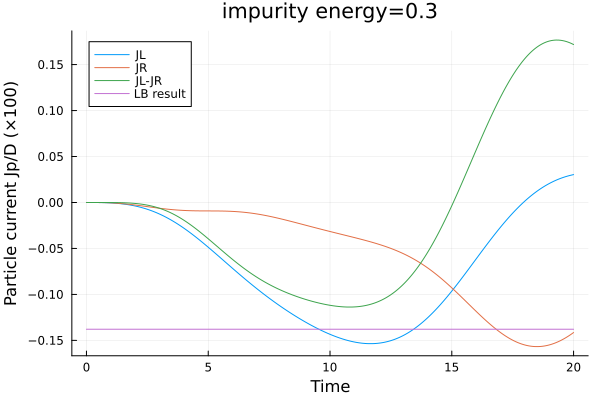

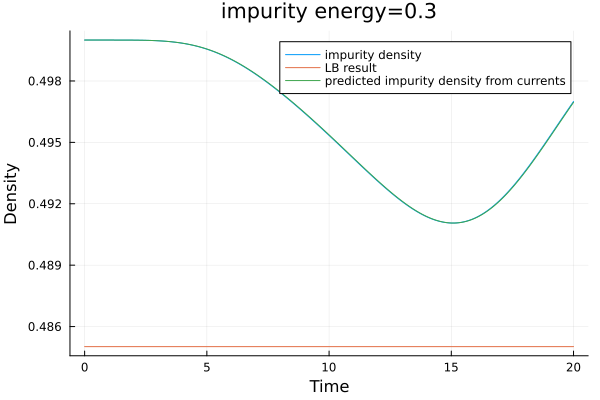

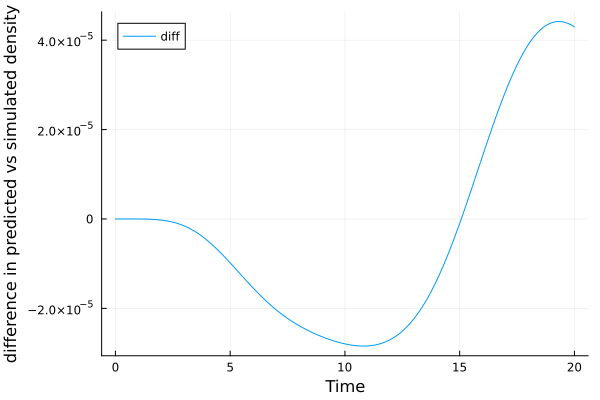

In [4]:
function Exact_propagation_(P,DP,BP)
    (;δt1,δt2) = P
    (;times1,times2) = DP
    (;H_single,Ci) = BP
    n1 = length(times1)
    n2 = length(times2)
    
    exact_corrs = Any[]
    U_step1= exp(-im*δt1*H_single)
    U_step2 = exp(-im*δt2*H_single)
    push!(exact_corrs,Ci)
    for i in ProgressBar(1:n1)
        corr_term = U_step1*last(exact_corrs)*U_step1'
        push!(exact_corrs,corr_term)
    end
    for i in ProgressBar((n1+1):n1+n2)
        corr_term = U_step2*last(exact_corrs)*U_step2'
        push!(exact_corrs,corr_term)
    end
    return exact_corrs
end
exact_corrs= Exact_propagation_(P,DP,BP);

JL_list_ex,JR_list_ex,den_list_ex,Jp,n = sim_currents(exact_corrs,DP,P,BP)
Jp,_,n = LB_current(P,DP)
current_plots(JL_list_ex,JR_list_ex,den_list_ex,Jp,n,P,DP)

In [28]:
Base.summarysize(x)/(10^9)

3.226724304

In [27]:
x = randomMPS(s,linkdims=2500)

MPS
[1] ((dim=2|id=329|"Fermion,Site,n=1"), (dim=2500|id=567|"Link,l=1"))
[2] ((dim=2500|id=567|"Link,l=1"), (dim=2|id=522|"Fermion,Site,n=2"), (dim=2500|id=864|"Link,l=2"))
[3] ((dim=2500|id=864|"Link,l=2"), (dim=2|id=661|"Fermion,Site,n=3"), (dim=2500|id=20|"Link,l=3"))
[4] ((dim=2500|id=20|"Link,l=3"), (dim=2|id=722|"Fermion,Site,n=4"), (dim=2500|id=129|"Link,l=4"))
[5] ((dim=2500|id=129|"Link,l=4"), (dim=2|id=719|"Fermion,Site,n=5"), (dim=2500|id=290|"Link,l=5"))
[6] ((dim=2500|id=290|"Link,l=5"), (dim=2|id=902|"Fermion,Site,n=6"), (dim=2500|id=616|"Link,l=6"))
[7] ((dim=2500|id=616|"Link,l=6"), (dim=2|id=210|"Fermion,Site,n=7"), (dim=2500|id=449|"Link,l=7"))
[8] ((dim=2500|id=449|"Link,l=7"), (dim=2|id=620|"Fermion,Site,n=8"), (dim=2500|id=781|"Link,l=8"))
[9] ((dim=2500|id=781|"Link,l=8"), (dim=2|id=36|"Fermion,Site,n=9"), (dim=2500|id=686|"Link,l=9"))
[10] ((dim=2500|id=686|"Link,l=9"), (dim=2|id=139|"Fermion,Site,n=10"), (dim=2500|id=958|"Link,l=10"))
[11] ((dim=2500|id=958|"Li

size(Sm[m]) = (8, 8)
size(Z) = (8, 8)
size(Sm[m]) = (8, 8)
size(Z) = (8, 8)
size(Sm[m]) = (8, 8)
size(Z) = (8, 8)
here1


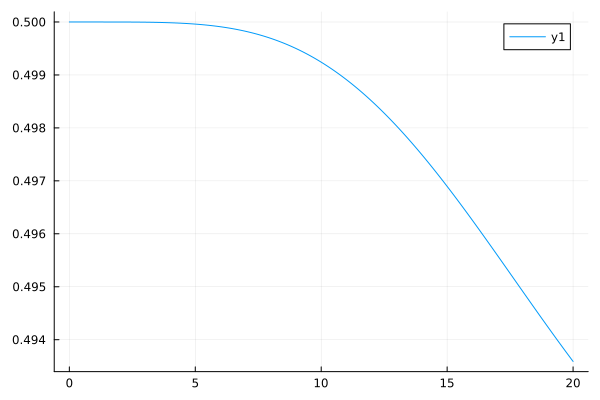

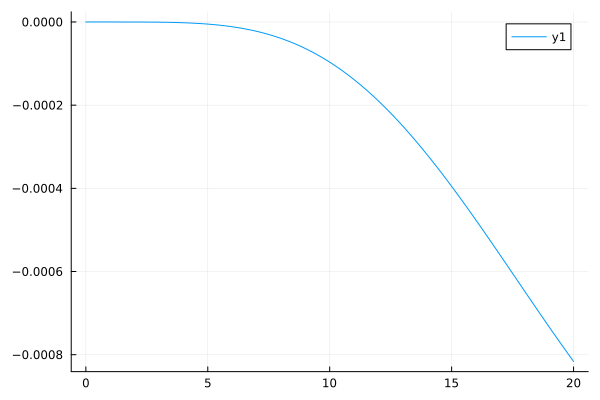

In [6]:

M = Ns
Sz,Sp,Sm,Num = spin_operators(M)
Ge,Gd = two_site_diss_rates(P,DP)
HS = HS_full(P,DP,BP)


ind =1
tvec = [times1;times2]
ρ_init = vectorise_ρ(ψ_init,P,DP)
L,JL_op,JR_op = build_liouvillian(HS,Sp,Sm,Sz,Num,Ge,Gd,M)

ρ_list,Λ,ρ_ness = Liouvillian_solver_exact(L,tvec,ρ_init)
pushfirst!(tvec,0.0)
Nt = length(tvec)
corr_mast = Any[]
den_mast = Any[]
JL_mast,JR_mast = Any[],Any[]

for i=1:Nt
    ρvec = unvectorise_ρ(ρ_list[i],true)
    corr = ρ_system_corr(ρvec,DP,P)
    push!(corr_mast,corr)
    push!(den_mast,corr[ind,ind])
    push!(JL_mast,tr((unvectorise_ρ(JL_op*ρ_list[i],false))))
    push!(JR_mast,tr((unvectorise_ρ(JR_op*ρ_list[i],false))))
end
corr_ness = ρ_system_corr(unvectorise_ρ(ρ_ness,true),DP,P)
display(plot(tvec,real.(den_mast)))
display(plot(tvec,real.(JR_mast)))


In [38]:
zeros(10)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [12]:
JL_NESS_l

Any[]

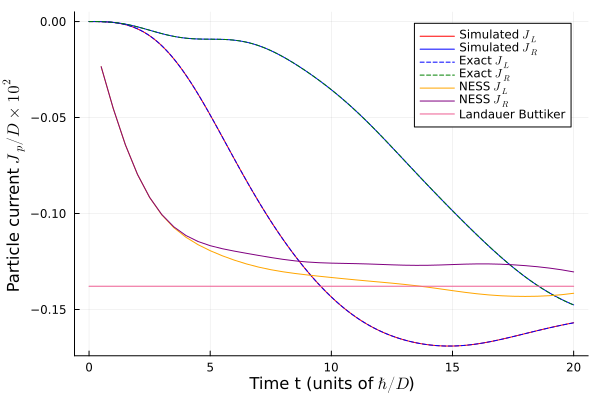

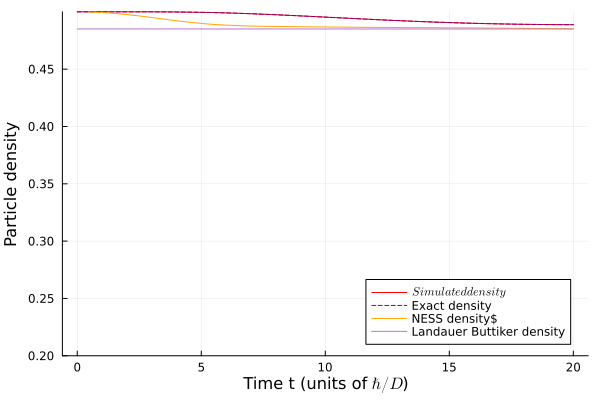

In [12]:
fac = 100/D
t = [times1;times2]#sim_density(JL_list,JR_list,den_list,P,DP)[3]
pushfirst!(t,0)
Jp,_,n_LB = LB_current(P,DP)
Jp = Jp*ones(length(t))
n_LB = n_LB*ones(length(t))
plot(t, real.(fac*JL_list), label=L"Simulated $J_{L}$", linecolor=:red)
plot!(t, real.(fac*JR_list), label=L"Simulated $J_{R}$", linecolor=:blue)
#plot(t, real.(fac*JL_mast), label=L"Simulated $J_{L}$ using master equation", linecolor=:black)
#plot!(t, real.(fac*JR_mast), label=L"Simulated $J_{R}$ using master equation", linecolor=:purple)
plot!(t, real.(fac*JL_list_ex), label=L"Exact $J_{L}$", linestyle=:dash, linecolor=:blue)
plot!(t, real.(fac*JR_list_ex), label=L"Exact $J_{R}$", linestyle=:dash, linecolor=:green)
plot!(NESS_t_list, real.(fac*JL_NESS_l), label=L"NESS $J_{L}$", linecolor=:orange)
plot!(NESS_t_list, real.(fac*JR_NESS_l), label=L"NESS $J_{R}$", linecolor=:purple)
display(plot!(t, fac*Jp,label="Landauer Buttiker",xlabel=L"Time t (units of $\hbar/D$)", ylabel=L"Particle current $J_{p}/D \times 10^{2}$"))
# #savefig("Current_plots_PreB_parameters.png")

plot(t, real.(den_list), label=L"Simulated density", linecolor=:red)
#plot!(t,real.(den_mast),label="Simulated density using master equation",linecolor=:blue)
plot!(t, real.(den_list_ex), label="Exact density", linestyle=:dash, linecolor=:purple)
plot!(NESS_t_list, real.(den_NESS_l), label=L"NESS density$", linecolor=:orange)
display(plot!(t, n_LB,label="Landauer Buttiker density",xlabel=L"Time t (units of $\hbar/D$)", ylabel="Particle density",ylim=[0.2,0.5]))

In [16]:
 #This file is a part of Julia. License is MIT: https://julialang.org/license

struct RUsage
    ru_utime_sec::Clong         #  user CPU time used
    ru_utime_usec::Clong        #  user CPU time used
    ru_stime_sec::Clong         #  system CPU time used
    ru_stime_usec::Clong        #  system CPU time used
    ru_maxrss::Clong            #  maximum resident set size
    ru_ixrss::Clong             #  integral shared memory size
    ru_idrss::Clong             #  integral unshared data size
    ru_isrss::Clong             #  integral unshared stack size
    ru_minflt::Clong            #  page reclaims (soft page faults)
    ru_majflt::Clong            #  page faults (hard page faults)
    ru_nswap::Clong             #  swaps
    ru_inblock::Clong           #  block input operations
    ru_oublock::Clong           #  block output operations
    ru_msgsnd::Clong            #  IPC messages sent
    ru_msgrcv::Clong            #  IPC messages received
    ru_nsignals::Clong          #  signals received
    ru_nvcsw::Clong             #  voluntary context switches
    ru_nivcsw::Clong            #  involuntary context switches
end

function get_vmsize()
    ru = Vector{RUsage}(undef, 1)
    ccall(:getrusage, Cint, (Cint, Ptr{Cvoid}), 0, ru)
    return ru[1].ru_maxrss
end

function run_mtest(name, testf)
    print("Testing $name...")
    for i in 1:2
        print("priming process...")
        testf()
    end
    vm1 = get_vmsize()
    println("monitored run...")
    testf()
    vm2 = get_vmsize()

    diff = vm2 - vm1
    WARN = (diff > 1000) ? "<===================================== WARNING" : ""
    println("Memory Test ($name) : VMSize difference : $diff KB $WARN")
end


function mtest_create_strings()
    for i in 1:10^8
        string("$i")
    end
    GC.gc()
end

function mtest_remotecall_fetch()
    for i in 1:10^5
        remotecall_fetch(myid, 1)
    end
    GC.gc()
end

run_mtest("create_strings", () -> mtest_create_strings())
run_mtest("remotecall_fetch", () -> mtest_remotecall_fetch(

Testing create_strings...priming process...priming process...

LoadError: could not load symbol "getrusage":
The specified procedure could not be found. 

In [17]:
using Sys

function get_memory_usage()
    # Get the current process ID
    pid = Sys.getpid()

    # Call GetProcessMemoryInfo to retrieve memory usage information
    memory_info = Sys.GetProcessMemoryInfo(pid)

    # Extract the working set size from the memory information
    working_set_size = memory_info.WorkingSetSize

    return working_set_size
end

# Call the get_memory_usage function to retrieve memory usage
memory_usage = get_memory_usage()

println("Memory usage: $memory_usage bytes")

LoadError: ArgumentError: Package Sys not found in current path, maybe you meant `import/using .Sys`.
- Otherwise, run `import Pkg; Pkg.add("Sys")` to install the Sys package.

In [44]:
T = 50
T_unenriched = round(T-T_enrich,digits=10)       # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en = Int(T_enrich/(n1*δt1))
nframe_un = Int(T_unenriched/(n2*δt2))
nframe = nframe_en + nframe_un
times1ex = Vector(LinRange(δt1,T_enrich, Int(ceil(T_enrich/δt1))))
times2ex = Vector(LinRange(T_enrich+δt2,T, Int(ceil(T_unenriched/δt2))))
tex = [times1ex;times2ex]
pushfirst!(tex,0)

1001-element Vector{Float64}:
  0.0
  0.05
  0.1
  0.15
  0.19999999999999998
  0.25
  0.3
  0.35
  0.39999999999999997
  0.44999999999999996
  0.5
  0.5499999999999999
  0.6
  ⋮
 49.449999999999996
 49.5
 49.550000000000004
 49.6
 49.65
 49.7
 49.74999999999999
 49.8
 49.849999999999994
 49.900000000000006
 49.949999999999996
 50.0

|psi| = 305.234 KiB
After sweep 1: maxlinkdim=10 maxerr=5.04E-20 current_time=0.0 - 0.05im time=5.995
|psi| = 446.984 KiB
After sweep 2: maxlinkdim=10 maxerr=3.91E-18 current_time=0.0 - 0.1im time=0.745
|psi| = 446.984 KiB
After sweep 3: maxlinkdim=10 maxerr=5.77E-17 current_time=0.0 - 0.15im time=0.648
|psi| = 446.984 KiB
After sweep 4: maxlinkdim=10 maxerr=3.58E-16 current_time=0.0 - 0.2im time=0.682
|psi| = 447.609 KiB
After sweep 5: maxlinkdim=11 maxerr=1.43E-16 current_time=0.0 - 0.25im time=0.682
|psi| = 447.609 KiB
After sweep 6: maxlinkdim=11 maxerr=4.44E-16 current_time=0.0 - 0.3im time=0.529
|psi| = 448.266 KiB
After sweep 7: maxlinkdim=11 maxerr=8.52E-16 current_time=0.0 - 0.35im time=0.645
|psi| = 451.641 KiB
After sweep 8: maxlinkdim=13 maxerr=9.03E-16 current_time=0.0 - 0.4im time=0.539
|psi| = 454.453 KiB
After sweep 9: maxlinkdim=14 maxerr=9.42E-16 current_time=0.0 - 0.45im time=0.648
|psi| = 455.922 KiB
After sweep 10: maxlinkdim=14 maxerr=8.54E-16 current_time=0.0 - 0

|psi| = 1014.016 KiB
After sweep 6: maxlinkdim=44 maxerr=9.87E-16 current_time=0.0 - 0.3im time=1.057
|psi| = 1.016 MiB
After sweep 7: maxlinkdim=45 maxerr=9.46E-16 current_time=0.0 - 0.35im time=1.09
|psi| = 1.032 MiB
After sweep 8: maxlinkdim=45 maxerr=9.95E-16 current_time=0.0 - 0.4im time=1.084
|psi| = 1.049 MiB
After sweep 9: maxlinkdim=45 maxerr=9.94E-16 current_time=0.0 - 0.45im time=1.117
|psi| = 1.067 MiB
After sweep 10: maxlinkdim=46 maxerr=9.58E-16 current_time=0.0 - 0.5im time=1.167
sim_t = 4.0
 29.618407 seconds (317.96 k allocations: 789.906 MiB, 0.14% gc time)
|psi| = 1.088 MiB
After sweep 1: maxlinkdim=46 maxerr=9.77E-16 current_time=0.0 - 0.05im time=1.209
|psi| = 1.103 MiB
After sweep 2: maxlinkdim=46 maxerr=9.92E-16 current_time=0.0 - 0.1im time=1.153
|psi| = 1.123 MiB
After sweep 3: maxlinkdim=46 maxerr=9.98E-16 current_time=0.0 - 0.15im time=1.2
|psi| = 1.151 MiB
After sweep 4: maxlinkdim=47 maxerr=9.98E-16 current_time=0.0 - 0.2im time=1.268
|psi| = 1.173 MiB
Afte

|psi| = 6.602 MiB
After sweep 2: maxlinkdim=121 maxerr=9.91E-16 current_time=0.0 - 0.1im time=4.766
|psi| = 6.791 MiB
After sweep 3: maxlinkdim=122 maxerr=9.86E-16 current_time=0.0 - 0.15im time=4.837
|psi| = 6.974 MiB
After sweep 4: maxlinkdim=123 maxerr=1.00E-15 current_time=0.0 - 0.2im time=5.084
|psi| = 7.142 MiB
After sweep 5: maxlinkdim=124 maxerr=9.97E-16 current_time=0.0 - 0.25im time=5.298
|psi| = 7.310 MiB
After sweep 6: maxlinkdim=126 maxerr=9.94E-16 current_time=0.0 - 0.3im time=5.574
|psi| = 7.502 MiB
After sweep 7: maxlinkdim=127 maxerr=9.95E-16 current_time=0.0 - 0.35im time=5.81
|psi| = 7.679 MiB
After sweep 8: maxlinkdim=129 maxerr=1.00E-15 current_time=0.0 - 0.4im time=6.003
|psi| = 7.889 MiB
After sweep 9: maxlinkdim=130 maxerr=9.98E-16 current_time=0.0 - 0.45im time=6.19
|psi| = 8.095 MiB
After sweep 10: maxlinkdim=132 maxerr=9.96E-16 current_time=0.0 - 0.5im time=6.529
sim_t = 8.0
209.982407 seconds (326.11 k allocations: 5.590 GiB, 0.15% gc time)
|psi| = 8.342 MiB

|psi| = 45.005 MiB
After sweep 7: maxlinkdim=300 maxerr=1.29E-15 current_time=0.0 - 0.35im time=37.847
|psi| = 45.926 MiB
After sweep 8: maxlinkdim=300 maxerr=1.47E-15 current_time=0.0 - 0.4im time=39.231
|psi| = 46.772 MiB
After sweep 9: maxlinkdim=300 maxerr=1.66E-15 current_time=0.0 - 0.45im time=39.535
|psi| = 47.510 MiB
After sweep 10: maxlinkdim=300 maxerr=1.87E-15 current_time=0.0 - 0.5im time=40.116
sim_t = 11.5
2136.873842 seconds (386.32 k allocations: 28.428 GiB, 0.12% gc time)
|psi| = 48.308 MiB
After sweep 1: maxlinkdim=300 maxerr=2.10E-15 current_time=0.0 - 0.05im time=41.406
|psi| = 49.039 MiB
After sweep 2: maxlinkdim=300 maxerr=2.37E-15 current_time=0.0 - 0.1im time=42.199
|psi| = 49.817 MiB
After sweep 3: maxlinkdim=300 maxerr=2.66E-15 current_time=0.0 - 0.15im time=42.497
|psi| = 50.386 MiB
After sweep 4: maxlinkdim=300 maxerr=2.99E-15 current_time=0.0 - 0.2im time=43.48
|psi| = 50.981 MiB
After sweep 5: maxlinkdim=300 maxerr=3.35E-15 current_time=0.0 - 0.25im time=4

|psi| = 125.871 MiB
After sweep 4: maxlinkdim=300 maxerr=2.82E-11 current_time=0.0 - 0.2im time=114.542
|psi| = 126.319 MiB
After sweep 5: maxlinkdim=300 maxerr=2.92E-11 current_time=0.0 - 0.25im time=114.563
|psi| = 126.742 MiB
After sweep 6: maxlinkdim=300 maxerr=3.02E-11 current_time=0.0 - 0.3im time=114.967
|psi| = 127.209 MiB
After sweep 7: maxlinkdim=300 maxerr=3.13E-11 current_time=0.0 - 0.35im time=115.987
|psi| = 127.748 MiB
After sweep 8: maxlinkdim=300 maxerr=3.24E-11 current_time=0.0 - 0.4im time=116.357
|psi| = 128.326 MiB
After sweep 9: maxlinkdim=300 maxerr=3.35E-11 current_time=0.0 - 0.45im time=116.713
|psi| = 128.826 MiB
After sweep 10: maxlinkdim=300 maxerr=3.47E-11 current_time=0.0 - 0.5im time=117.785
sim_t = 19.0
2580.860471 seconds (404.06 k allocations: 34.823 GiB, 0.10% gc time)
|psi| = 129.414 MiB
After sweep 1: maxlinkdim=300 maxerr=3.59E-11 current_time=0.0 - 0.05im time=121.167
|psi| = 129.895 MiB
After sweep 2: maxlinkdim=300 maxerr=3.72E-11 current_time=0

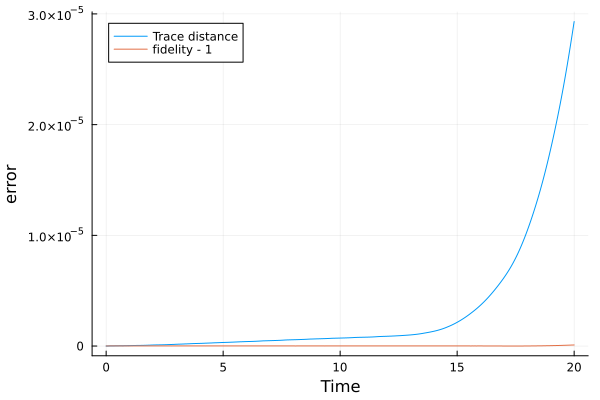

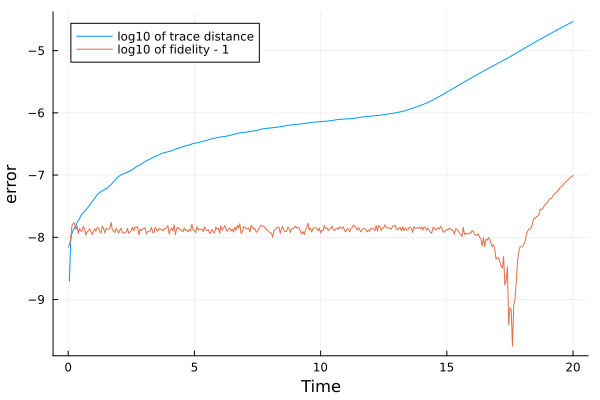

n = 400


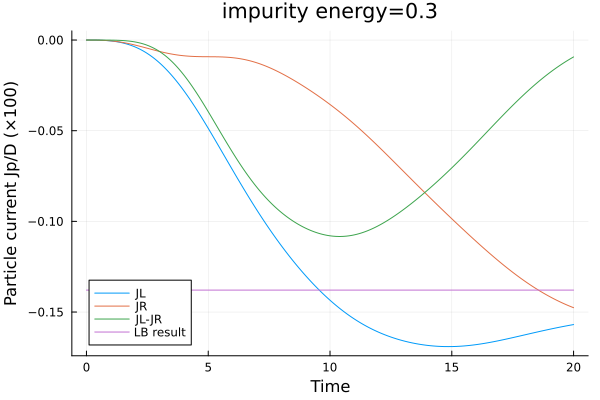

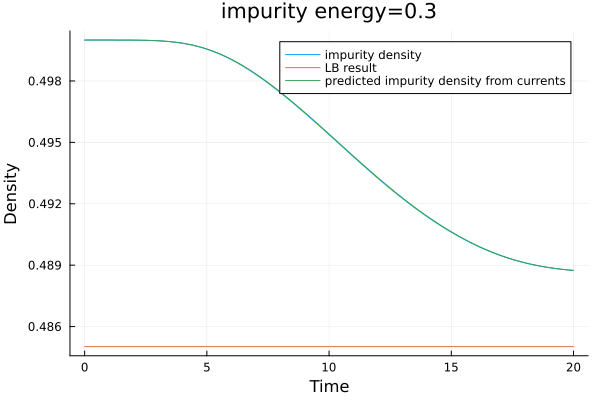

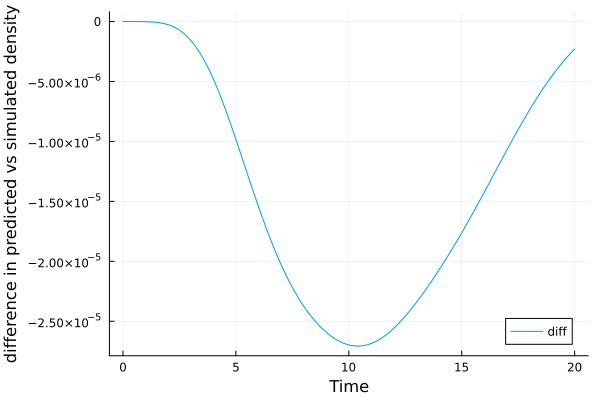

In [7]:
NESS_data = Any[]
Λ_list = Any[]
NESS_t_list = Any[]
#a_b_plots(times1,times2,mu_L,mu_R,β_L,β_R,Jl,Jr)
ρ_list = Any[]
(;tdvp_cutoff) = P
#------------------------------------------------------------------------------
ψe = deepcopy(ψ_init)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN,"Mem" =>measure_mem)
sim_t = 0
for i =1:nframe_en #ProgressBar(1:(nframe_en))
    
    global ψe = tdvp(H,-im * n1*δt1,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff,mindim=10,maxdim=300, 
        outputlevel=1, normalize=false, (observer!)=obs)
    global sim_t += n1*δt1
    @show(sim_t)
    
    ##Enrichment
    Krylov_i = Krylov_states(H,ψe,P,DP);
    ψe2 = enrich_generic3(ψe, Krylov_i; P)
    @show( abs(1-inner(ψe2,ψe)))
    ψe = ψe2
    
    #extraction of NESS
    push!(NESS_t_list,sim_t)
    @time push!(Λ_list, NESS_fn(ψe,P,DP)[2])

end
ψf = ψe
#ψe = nothing
for i =1:nframe_un #ProgressBar(1:(nframe_un))
    global ψf = tdvp(H,-im * n2*δt2,ψf; time_step = -im * δt2, cutoff = tdvp_cutoff,mindim=10,maxdim=300,
       outputlevel=1, normalize=false, (observer!)=obs)
     global sim_t += n2*δt2
         @show(sim_t)
        
#     if sum(boundary_test(ψf,N,num_init))>0
#         println("boundary reached at t="*string(sim_t))
#         break
#     end
     
    ##Extraction of NESS
     push!(NESS_t_list,sim_t)
     @time push!(Λ_list, NESS_fn(ψf,P,DP)[2])
end

#--------------------------------------------------------------------------------------------
res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"]; 
pushfirst!(corr,BP.Ci)

#spec_l,vec_l,mat_l,JL_NESS_l,JR_NESS_l,den_NESS_l,fid_l,tr_l = NESS_calculations(Λ_list,DP,P)

#------------------------------------------------------------------------------------------------
JL_list = []
JR_list = []
den_list = []


JL_list,JR_list,den_list,Jp,n = sim_currents(corr,DP,P,BP)

"""
Bottle neck is the Krylov states.
"""
ρi = vectorise_ρ(ψ_init,P,DP)
Λmat = NESS_fn(ψf,P,DP)[2]
map_check(ψf,ψ_init,Λmat,P,DP)
println("ρf - Λmat*ρi="*string(map_check(ψf,ψ_init,Λmat,P,DP)))

#plot(NESS_t_list,map_check2(ρ_list,Λ_list,ρi),title="ρf - Λmat*ρi")
#varinfo()

exact_corrs = error_prop(corr,P,DP,BP);

current_plots(JL_list,JR_list,den_list,Jp,n,P,DP)

In [40]:
Jp,Je,n_LB = LB_current(P,DP)

3-element Vector{Float64}:
 0.002290129723988195
 1.4863865865322507e-5
 0.4815187942144842

In [34]:
Λ_list

40-element Vector{Any}:
 ComplexF64[0.9921386856516881 + 3.053113317719181e-16im -5.974002380622019e-11 + 1.1293878950366302e-9im … 1.5533624431416769e-12 - 1.814402625856059e-12im 1.5516407991182737e-5 + 5.08219768352647e-21im; -5.409194817893515e-9 + 6.57226287432273e-10im 0.9796146527932537 + 0.1482520753919898im … 7.398534468993105e-11 - 8.484568181580746e-11im -1.8082057746301893e-12 + 1.7693380695125389e-13im; … ; -2.109648706231687e-11 - 4.85724030259648e-12im -1.5473863287264774e-10 - 5.409692696293982e-10im … 0.9798443874724075 - 0.1482868835022293im 9.950941669886966e-10 + 1.4727426848247898e-9im; 1.5497077347604254e-5 - 2.6258021364883317e-20im 2.2451376029219234e-11 + 9.543071748264358e-12im … -5.400978631786763e-9 + 1.5034014848701958e-9im 0.9921338230036444 - 7.216449660063518e-16im]
 ComplexF64[0.9696661303261035 + 2.7755575615628914e-16im -5.63966826859408e-9 - 3.705303972305812e-9im … 1.1785832949915362e-11 - 4.4287922402079124e-11im 0.00023453209864895743 - 2.71050543

In [8]:
spec_l,vec_l,mat_l,JL_NESS_l,JR_NESS_l,den_NESS_l,fid_l,tr_l = NESS_calculations(Λ_list,DP,P);

In [27]:
NESS_bool = true

current_plots_NESS(JL_NESS_l,JR_NESS_l,den_NESS_l,Jp,NESS_t_list,NESS_bool,P)
NESS_plots_new(fid_l,tr_l,spec_l,NESS_t_list)

Jp = [-0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584, -0.0014023022985452584]


LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:40]

[ Info: Saved animation to C:\Users\mf22297\OneDrive - University of Bristol\Documents\PreB project\entanglement_entropy_anim,T=30.0.gif


Plots.AnimatedGif("C:\\Users\\mf22297\\OneDrive - University of Bristol\\Documents\\PreB project\\entanglement_entropy_anim,T=30.0.gif")
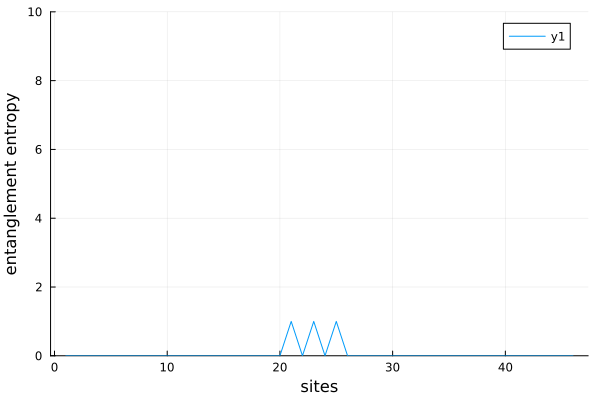

In [24]:

site_lim = N
SvN_ylim = 10
entanglement_animation(SvN,site_lim, SvN_ylim,P,DP)

In [ ]:
function current_plots_NESS(JL_list,JR_list,den_list,Jp,times,NESS_bool)
    if NESS_bool
        current_title = "NESS currents"
        density_title = "NESS density"
    else
        current_title = "Currents"
        density_title = "Density"
    end
    Jp = Jp*ones(length(times))
    plot(times,real.(JL_list),label="JL",xlabel="Time",ylabel="Particle current")
    plot!(times,real.(JR_list),label="JR")
    @show(Jp)
    #plot(times,real.(Jp))
    display(plot!(times,real.(Jp),label="LB result",title =current_title))
    display(plot(times,real.(den_list),label="Density",title = density_title))
end

[ Info: Saved animation to C:\Users\mf22297\OneDrive - University of Bristol\Documents\PreB project\density_animation,T=70.0.gif


Plots.AnimatedGif("C:\\Users\\mf22297\\OneDrive - University of Bristol\\Documents\\PreB project\\density_animation,T=70.0.gif")
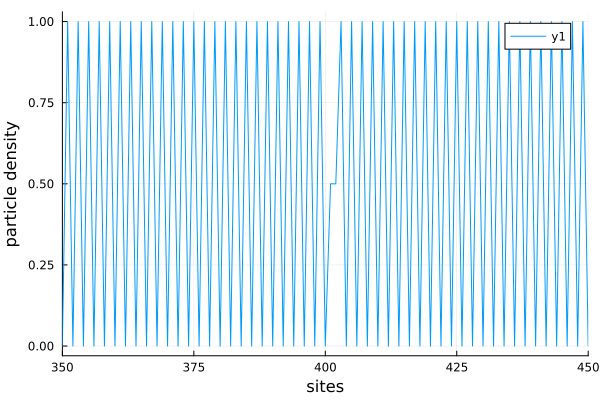

In [10]:
x = 1:N
    anim = @animate for i=1:length(exact_corrs)
        f(x) = abs((exact_corrs[i])[x,x])
        plot(x,f,xlabel="sites",ylabel="particle density" ,xlim=(350,450))
    end
    gif(anim,"density_animation,T="*string(T)*".gif")

[ Info: Saved animation to C:\Users\mf22297\OneDrive - University of Bristol\Documents\PreB project\correlation_surface_plot_anim,T=2.0.gif


Plots.AnimatedGif("C:\\Users\\mf22297\\OneDrive - University of Bristol\\Documents\\PreB project\\correlation_surface_plot_anim,T=2.0.gif")
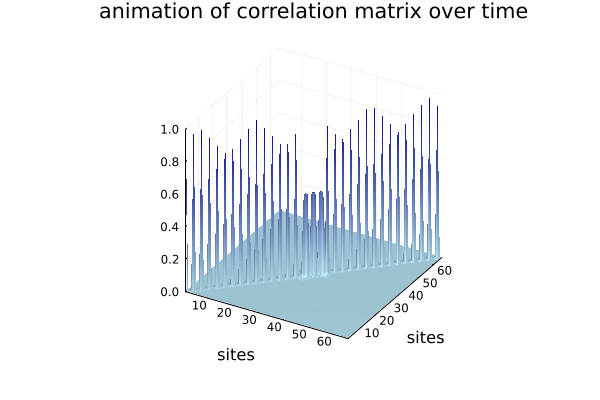

In [15]:
correlation_surface_plot(corr,site_lim,P,DP)

[ Info: Saved animation to C:\Users\mf22297\OneDrive - University of Bristol\Documents\PreB project\entanglement_entropy_anim,T=2.0.gif


Plots.AnimatedGif("C:\\Users\\mf22297\\OneDrive - University of Bristol\\Documents\\PreB project\\entanglement_entropy_anim,T=2.0.gif")
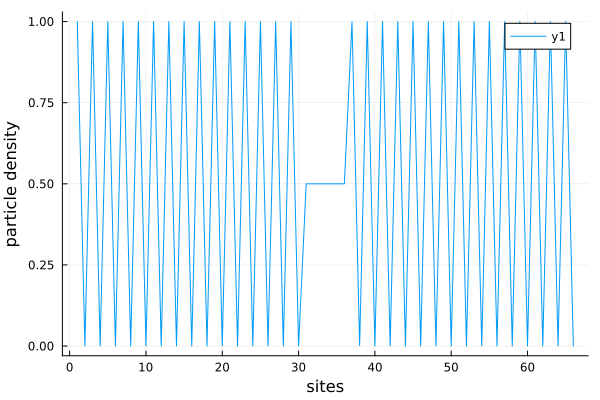

In [14]:
site_lim = N
impurity_density_animation(corr,site_lim,P,DP)

In [15]:
"Spectral function test"

function orthopol_chain_(spec_therm,side,P)

    if side=="left"
        Nb = P.Nbl
    elseif side=="right"
        Nb = P.Nbr
    else
        error("No side chosen.")
    end
    w(t) = J(t, spec_therm, side, P)
    supp = (-1,1)
    degree = Nb-1
    my_meas = Measure("my_meas", w, supp, false, Dict())
    my_op = OrthoPoly("my_op", degree, my_meas; Nquad=100000);
    α_coeffs,β_coeffs = coeffs(my_op)[:,1],coeffs(my_op)[:,2]
    en = α_coeffs
    Vk = sqrt.(β_coeffs)
    
    #Now we form rotate the bath modes such that we have a star geometry. This is done
    #by diagonalising the bath modes.

    A,U = zeros(Nb+1,Nb+1),zeros(Nb+1,Nb+1)
    A[1,1],U[1,1] = 1,1

    for i =2:Nb+1
        A[i,i] = en[i-1]
        A[i-1,i] = Vk[i-1]
        A[i,i-1] = conj(Vk[i-1])
    end
    A_sub = A[2:Nb+1,2:Nb+1]
    U_sub = eigen(A_sub).vectors
    U[2:Nb+1,2:Nb+1] = U_sub
    A_star = U'*A*U

    ###Pretty sure its this way and not [1,2:Nb+1]
    Vk = A_star[2:Nb+1,1]
    en = diag(A_star)[2:Nb+1]


    return Vk,en
end


function approx_J_(J,ϵ_b,V_k,spec_therm,side,P)

    N = length(ϵ_b)
    η = 1/N
    samp = 10000; # Frequency sampling.
    w = range(-1.5,1.5,samp); # Frequency axis for Landauer calculations (slightly larger than the band).
    J_approx = zeros(samp)
    for i=1:N
        denom = (w .-ϵ_b[i]).^2 .+(η)^2
        L = η./(π*denom)
        delta = (V_k[i]^2)*L
       # display(plot(w,real.(delta)))
       # display(plot(w,delta)) 
        J_approx += delta
    end
    J_exact = J(w,spec_therm,side,P)
    plot(w,J_exact)
  #  @show(J_approx)
    display(plot!(w,real.(J_approx)))

end

BP.Vk_emp_L,BP.ϵb_emp_L =orthopol_chain_("empty","right",P)
BP.Vk_fill_L,BP.ϵb_fill_L =orthopol_chain_("filled","right",P)
#approx_J(J,ϵ_b,V_k,spec_therm,side,P)
approx_J_(J,BP.ϵb_fill_L,BP.Vk_fill_L,"filled","right",P)
approx_J_(J,BP.ϵb_emp_L,BP.Vk_emp_L,"empty","right",P)

# x = 1:Nbr
# xlim = (1,Nbr)
# plot(x,real.(BP.Vk_emp_L/D),label = "empty chain couplings",xlim=xlim)
# display(plot!(x,real.(BP.Vk_fill_L/D),label="filled chain couplings",xlim=xlim))
# plot(x,real.(BP.ϵb_emp_L/D),label = "empty chain energies",xlim=xlim)
# display(plot!(x,real.(BP.ϵb_fill_L/D),label="filled chain energies",xlim=xlim))

# plot(x,real.(BP.Vk_emp_R/D),label = "empty chain couplings",xlim=xlim)
# display(plot!(x,real.(BP.Vk_fill_R/D),label="filled chain couplings",xlim=xlim))
# plot(x,real.(BP.ϵb_emp_R/D),label = "empty chain energies",xlim=xlim)
# display(plot!(x,real.(BP.ϵb_fill_R/D),label="filled chain energies",xlim=xlim))

LoadError: MethodError: no method matching stieltjes(::Int64, ::Vector{Float64}, ::Vector{ComplexF64})
[0mClosest candidates are:
[0m  stieltjes(::Int64, ::AbstractVector{<:Real}, [91m::AbstractVector{<:Real}[39m; removezeroweights) at C:\Users\mf22297\.julia\packages\PolyChaos\zO2p7\src\stieltjes.jl:21

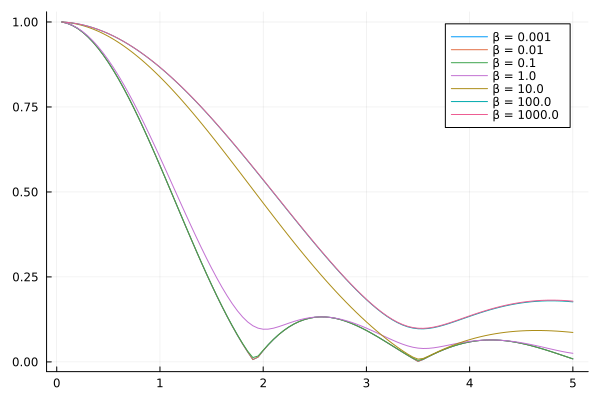

In [5]:
mu_L =0
βvec = [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]    
for j =1:length(βvec)
    β_L = βvec[j]
    
    for i=1:length(times)
        a_L[i] = abs(a_b_fns(Jl,times[i],mu_L,β_L)[1])
        b_L[i] = abs(a_b_fns(Jl,times[i],mu_L,β_L)[2])
    end
    if j ==1
        plot(times,(b_L)/abs(b_L[1]),label="β = "*string(β_L))
    elseif j<length(βvec)
        plot!(times,(b_L)/abs(b_L[1]),label="β = "*string(β_L))
    else
        display(plot!(times,(b_L)/abs(b_L[1]),label="β = "*string(β_L)))
    end
end

θ =π/2-0.1
ϕ = π+0.1
α = cos(θ)+im*sin(θ)
β = cos(ϕ)+im*sin(ϕ)
mag = sqrt(abs(α)^2 + abs(β)^2)
α /= mag
β /= mag
i = s[1]
T = single_site_unitary(α,β,i)
newA = T*ψ[1]
noprime!(newA)
ψ[1] = newA